# Second COMP421 Assignment
## A: Principal Components Analysis

Find the first few Principal Components of the sklearn digits data (ie. the data from  the [kNN example](https://github.com/garibaldu/comp421/blob/master/notebooks/knn_on_little_digits.ipynb)), and show them as images. It doesn't really matter how you do this - perhaps sklearn itself can do it for you?

In [1]:
import autograd.numpy as np
import sklearn.datasets as ds
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
digits = ds.load_digits()
X = digits.data
print(X.shape)

(1797, 64)


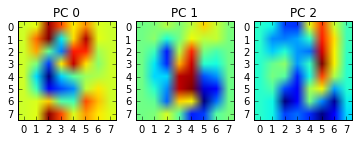

In [132]:
desired_n_components = 3

# Calculate the principal components of the digits data.
pca = PCA(n_components=desired_n_components)
pca.fit(X)

fig = plt.figure()
for i in range(desired_n_components):
    fig.add_subplot(1, desired_n_components, i + 1)
    plt.imshow(np.reshape(pca.components_[i], (8, 8)))
    plt.title("PC " + str(i))

## B: autoencoding with linear hidden layer

In [9]:
import os
from autograd import grad
from autograd.util import flatten_func
from six.moves import cPickle as pickle

In [6]:
batch_size = 4
num_epochs = 1000
step_size = 0.001

num_batches = int(np.ceil(X.shape[0] / batch_size))

In [136]:
def init_weights(architecture):
    """Returns a list of weights for each layer
    in the neural network.
    """
    return [(np.random.randn(m, n),
             np.random.randn(n)) 
            for m, n in zip(architecture[:-1], architecture[1:])]

def batch_indices(iter):
    """Returns a slice indicating which training examples to
    use during the specified iteration.
    """
    idx = iter % num_batches
    return slice(idx * batch_size, (idx + 1) * batch_size)

def neural_net_predict(params, inputs, nonlin=None):
    """Performs a forward pass through a neural network. 
    
    If the nonlin param is set, then the weighted sum are 
    transformed into activations using the specified
    activation function.
    """
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = nonlin(outputs) if nonlin else outputs
            
    return outputs

def sse(predicted, target):
    """The sum of squared errors between the predicted values
    and targets.
    """
    return np.sum((target - predicted)**2)

def lin_objective(params, iter):
    """A linear objective function.
    """
    idx = batch_indices(iter)
    inputs = X[idx]
    predicted = neural_net_predict(params, inputs)
    # Since we're training an autoencoder, the targets are 
    # equal to the inputs.
    return sse(predicted, target=inputs)

grad_lin_objective = grad(lin_objective)

def adam(grad, init_params, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8, unfrozen=None):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf.
    
    Note that (rather confusingly), when unfrozen=None, all parameters are
    treated as unfrozen (i.e. all parameters are updated / learnt).
    """
    flattened_grad, unflatten, x = flatten_func(grad, init_params)
    
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
        g = flattened_grad(x, i)
        if callback: callback(i)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        # Only update the unfrozen weights.
        x[unfrozen] = x[unfrozen] - step_size*mhat[unfrozen]/(np.sqrt(vhat[unfrozen]) + eps)
    return unflatten(x)

Some utility functions...

In [142]:
def print_progress(iter):
    if iter % num_batches == 0:
        workdone = iter / (num_epochs * num_batches)
        print("\rTraining: [{0:50s}] {1:.1f}%".format('#' * int(workdone * 50), workdone*100), end="", flush=True)
        
def display_weights(params, hidden_unit, goal_weights, goal_title):
    """Plots the weights in params that connect to the specified
    hidden_unit against the goal_weights (goal_weights in this
    specific context will be one of the initial principal components.)
    """
    num_figs = len(params) + 1
    
    fig = plt.figure()

    fig.add_subplot(1, num_figs, 1)
    plt.imshow(np.reshape(goal_weights, (8, 8)))
    plt.title(goal_title)
    
    for i in range(len(params)):
        fig.add_subplot(1, num_figs, i + 2)
        layer_weights = (params[i])[0]
        if i == 0:
            plt.imshow(np.reshape(layer_weights[:,hidden_unit], (8, 8)))
        else:
            plt.imshow(np.reshape(layer_weights[hidden_unit,:], (8, 8)))
        plt.title("l%s weights" % str(i))

def visualise_predictions(params, data, num_predictions=5):
    """Displays the target value and what the neural net predicts
    for certain input examples.
    """
    for i in range(num_predictions):
        instance = np.random.randint(0, X.shape[0])
        test_predict = neural_net_predict(params, data[instance])
        
        fig = plt.figure()
        fig.add_subplot(1, 2, 1)
        plt.imshow(np.reshape(data[instance], (8, 8)), cmap="gray")
        plt.title("Target")
        fig.add_subplot(1, 2, 2)
        plt.imshow(np.reshape(test_predict, (8, 8)), cmap="gray")
        plt.title("neural_net_predict")

def pickle_params(fname, params, force=False):
    """Writes optimised weights / biases to memory, so we can use
    them later on without having to retrain the model.
    """
    fname = fname + ".pickle"
    
    if os.path.exists(fname) and not force:
        print("%s already present - Skipping pickling.")
    else:
        print("Pickling %s." % fname)
        
        try:
            with open(fname, "wb") as f:
                pickle.dump(params, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print("Unable to save data to", fname)

def read_pickle(fname):
    """Loads a pickle file and returns it as a python object.
    Used to load weights that have been previously learnt by 
    the network.
    """
    try:
        with open(fname, "rb") as f:
            print("Extracting from", fname)
            return pickle.load(f)
    except Exception as e:
        print("Unable to process data from", fname, ":", e)
        raise

In [124]:
# An autoencoder with a single hidden layer containing just one hidden unit.
architecture = [X.shape[1], 1, X.shape[1]]

weights = init_weights(architecture)

optimized_params = adam(grad_lin_objective, init_params=weights, step_size=step_size,
                       num_iters=(num_epochs * num_batches), callback=print_progress)

Training: [################################################# ] 99.9%

### Visualise the results
Now that the single layer, single hidden unit network has been trained, it's time to compare the weights that it learned with the first principal component, and take a look at some of the predictions of the network...

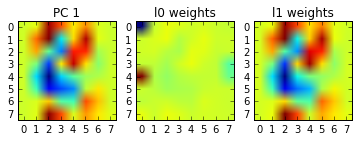

In [143]:
display_weights(optimized_params, hidden_unit=0, goal_weights=pca.components_[0], goal_title="PC 1")

The weights learnt by the "decoding" part of the autoencoder appear to be a linear combination of the first principal component. This intuitively makes sense, as by forcing the data through a one-unit layer, we are squashing it down to one dimension, and the network optimises the amount of information that we can gain from just one dimension.

Note that in order for the network to converge on the same weights as the principal component, tuning of the hyper parameters was needed. The network proved especially sensitive to the batch size. After visualising the predictions of the network, it became obvious that the network was learning to predict a "mean" image (Tony talked about his experience with this at a FOD a few weeks ago). To avoid this type of mean convergence, I dramatically decreased the batch size. A tipping point occurred when the batch size became less than the number of classes of images, and the average test error decreased significantly. My thinking of why this tipping point occurred has been along the lines of: The network previously had the potential to see an even distribution of every digit class per batch. Lowering the batch size beneath the number of classes meant that the network was learning from certain classes in a different proportion in each update, so these updates had less of a chance to "average" each other out, so to say.

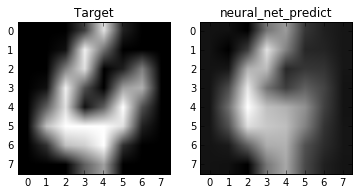

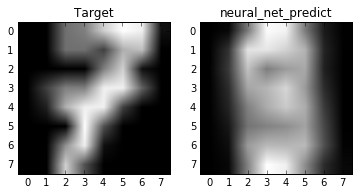

In [131]:
visualise_predictions(optimized_params, data=X, num_predictions=2)

In [ ]:
# This writes our parameters matrices to disk so that other programs
# / notebooks can use them without having to retrain the model.
pickle_params("adam_4_9_good", optimized_params)

### Now to freeze the first set of weights...
To do this, I pass a boolean mask to the adam optimizer, indicating which parameters should be updated in the update step. The boolean mask is "False" for indices that correspond to a parameter (weight or bias) connecting to the first hidden unit, and "True" for indices that correspond to a parameter connecting to the second hidden unit.

In this specific example, I've pretty much hardcoded the boolean mask (see function unfrozen_first_hidden_unit_mask()).

In [137]:
def unfrozen_first_hidden_unit_mask(architecture):
    """Returns a boolean mask indicating which weights are unfrozen. 
    
    The mask is one-dimensional, despite our weights matrix and bias matrix
    being two-dimensional, because the adam function flattens the parameters
    down into one dimension.
    """
    num_hidden_units = architecture[1]
    
    # Freeze the weights entering the first hidden unit.
    mask = [True if i % num_hidden_units else False for i in range(architecture[0] * num_hidden_units)]
    # Freeze the first bias.
    mask.extend([False])  
    # Unfreeze all other biases.
    mask.extend([True for i in range(num_hidden_units - 1)])
    # Freeze the weights leaving the first hidden unit.
    mask.extend([False if i < architecture[2] else True for i in range(architecture[2] * num_hidden_units)])
    # Unfreeze the bias weights for the final layer.
    mask.extend([True for i in range(architecture[2])])
    
    return np.array(mask)

In [138]:
# An autoencoder with a single hidden layer, but two hidden units.
architecture = [X.shape[1], 2, X.shape[1]]

weights = init_weights(architecture)

# Load the weights that the network learnt earlier and that we
# have verified match the first principal component closely.
optimized_params = read_pickle("adam_4_9_good.pickle")

# Insert the frozen weights into the correct rows / columns.
W0, b0 = weights[0]
optimized_W0, optimized_b0 = optimized_params[0]

W0[:,:-1] = optimized_W0
b0[:-1] = optimized_b0

W1, b1 = weights[1]
optimized_W1, _ = optimized_params[1]

W1[:-1,:] = optimized_W1

# We need to create a mask that tells our optimizer which weights
# to leave frozen, and which to update during training.
mask = unfrozen_first_hidden_unit_mask(architecture)

# Run the optimizer by passing the mask in.
second_order_params = adam(grad_objective, init_params=weights, step_size=step_size,
                       num_iters=(num_epochs * num_batches), callback=print_progress, unfrozen=mask)

Training: [################################################# ] 99.9%

#### Check that our initial weights remained unfrozen...
(This visualisation should correspond exactly to the visualisation done above, after learning the single hidden unit network on its own)

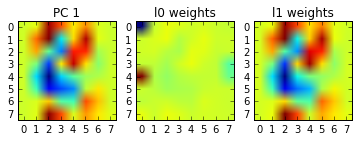

In [144]:
display_weights(second_order_params, hidden_unit=0, goal_weights=pca.components_[0], goal_title="PC 1")

#### Bingo. And now compare the weights to / from the second hidden unit with the second principal component...

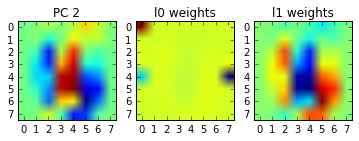

In [145]:
display_weights(second_order_params, hidden_unit=1, goal_weights=pca.components_[1], goal_title="PC 2")

The weights from the second hidden unit to the output layer can again be seen as a linear transformation of the second principal component.

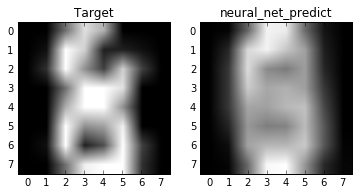

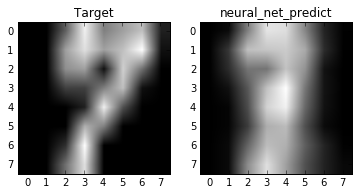

In [141]:
visualise_predictions(second_order_params, data=X, num_predictions=2)

### Training both hidden units at the same time...

In [105]:
architecture = [X.shape[1], 2, X.shape[1]]

weights = init_weights(architecture)

optimized_together_params = adam(grad_objective, init_params=weights, step_size=step_size,
                       num_iters=(num_epochs * num_batches), callback=print_progress)

Training: [################################################# ] 99.9%

__First principal component vs. weights of the first hidden unit__

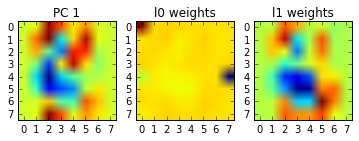

In [146]:
display_weights(optimized_together_params, hidden_unit=0, goal_weights=pca.components_[0], goal_title="PC 1")

__Second principal component vs. weights of the second hidden unit__

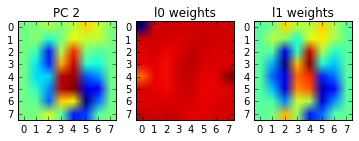

In [147]:
display_weights(optimized_together_params, hidden_unit=1, goal_weights=pca.components_[1], goal_title="PC 2")

When learned simultaneously, the weights still closely resemble the principal components of the data. In this specific example, the weights from the second hidden unit resemble the second principal component extremely closely, although it's possible (and previous examples have shown) that the first hidden unit learns the second principal component (and vice versa). Which principal component is learnt by which unit is dependent on the random initialisation.

In my network, the simultaneously learnt weights don't converge as closely to the principal components as they do when learnt individually. This was probably a consequence of the hyper parameter initialisation being tuned to the separate training case and then kept constant to allow comparison.

### C: the effect of nonlinearities
   1. now do the same (training all at once) with a hidden layer that involves a non-linearity (e.g. sigmoid, or relu).
   1. account for what you see.

In [115]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def nonlin_objective(params, iter):
    idx = batch_indices(iter)
    inputs = X[idx]
    # Note the inclusion of the nonlin parameter below.
    predicted = neural_net_predict(params, inputs, nonlin=sigmoid)
    # Since we're training an autoencoder, the targets are 
    # equal to the inputs.
    return sse(predicted, target=inputs)

grad_nonlin_objective = grad(nonlin_objective)

In [116]:
architecture = [X.shape[1], 2, X.shape[1]]

weights = init_weights(architecture)

optimized_nonlin_params = adam(grad_nonlin_objective, init_params=weights, step_size=step_size,
                       num_iters=(num_epochs * num_batches), callback=print_progress)

Training: [################################################# ] 99.9%

__First principal component vs. weights learnt by the first hidden unit__

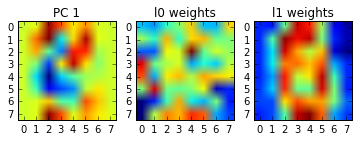

In [148]:
display_weights(optimized_nonlin_params, hidden_unit=0, goal_weights=pca.components_[0], goal_title="PC 1")

__Second principal component vs. weights learnt by the second hidden unit__

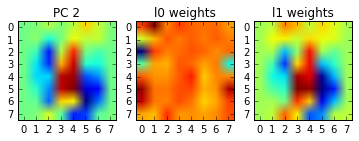

In [149]:
display_weights(optimized_nonlin_params, hidden_unit=1, goal_weights=pca.components_[1], goal_title="PC 2")

In all of my training examples, introducing nonlinearities